# <a id='toc1_'></a>[RAG streaming – best practice for printing citations in "accurate" mode](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [RAG streaming – best practice for printing citations in "accurate" mode](#toc1_)    
  - [The endpoint call](#toc1_1_)    
  - [The response objects](#toc1_2_)    
  - [Recommended best practice](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

When streaming RAG responses in the "accurate" citations mode, there can be occasional (less than 1% of the time) differences between the text as it is streamed token-by-token and the citations. This can cause citation offsets to be incorrect. 

This notebook demonstrates the recommended best practice to avoid this issue.

**NOTE:** At the moment, this is only supported with Cohere's v1 API. Support for the v2 API is coming soon.


In [ ]:
# ! pip install cohere

In [2]:
import cohere
co = cohere.Client("COHERE_API_KEY") # Get your free API key: https://dashboard.cohere.com/api-keys

## <a id='toc1_1_'></a>[The endpoint call](#toc0_)

In the following example, we pass some documents to the Chat endpoint call. We use the streaming mode and set the `citation_quality` value to "accurate".

We then print the complete stream of events from start to finish.


In [3]:
response = co.chat_stream(
    model="command-r-plus-08-2024",
    message="Where do the tallest penguins live?",
    documents=[
        {
            "title": "Tall penguins",
            "snippet": "Emperor penguins are the tallest.",
        },
        {
            "title": "Penguin habitats",
            "snippet": "Emperor penguins only live in Antarctica.",
        },
    ],
    citation_quality="accurate",
)

for event in response:
    print(event)
    print("-"*30)

event_type='stream-start' generation_id='2727918e-c7ad-4055-a2b2-c76727f2ebae' is_finished=False
------------------------------
event_type='search-results' search_results=None documents=[{'id': 'doc_0', 'snippet': 'Emperor penguins are the tallest.', 'title': 'Tall penguins'}, {'id': 'doc_1', 'snippet': 'Emperor penguins only live in Antarctica.', 'title': 'Penguin habitats'}] is_finished=False
------------------------------
event_type='text-generation' text='The' is_finished=False
------------------------------
event_type='text-generation' text=' tallest' is_finished=False
------------------------------
event_type='text-generation' text=' penguins' is_finished=False
------------------------------
event_type='text-generation' text=' are' is_finished=False
------------------------------
event_type='text-generation' text=' the' is_finished=False
------------------------------
event_type='text-generation' text=' Emperor' is_finished=False
------------------------------
event_type='text-ge

## <a id='toc1_2_'></a>[The response objects](#toc0_)

In the stream of events, notice that response generation happens twice:
- First, when it's streamed token-by-token (the`text-generation` events).
- Second, in the final event sent (the `stream-end` event).

There can be occasional times (less than 1% of the time) where these two sets of responses are not exactly the same. Either one could contain extra words, omitted words, or slightly rephrased segments.

Thus, if you printing the citations inline with the text response, this could cause the citation spans to be slightly offset. Refer to an example below:

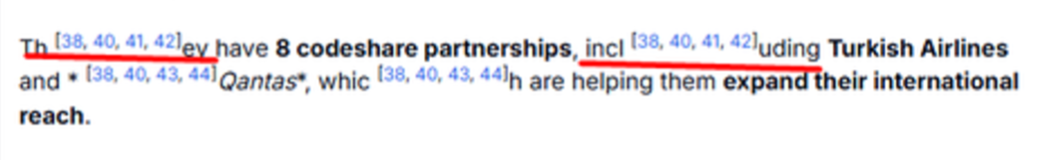

## <a id='toc1_3_'></a>[Recommended best practice](#toc0_)

To ensure that there is no offset in the citation spans, we recommend using the generated text and citations from the final generated event – the `stream-end` event.

The following shows how to access the text and citations from the final generated event.

In [10]:
print(event.response.text)

The tallest penguins are the Emperor penguins, which only live in Antarctica.


In [11]:
print(event.response.citations)

[ChatCitation(start=29, end=45, text='Emperor penguins', document_ids=['doc_0']), ChatCitation(start=66, end=77, text='Antarctica.', document_ids=['doc_1'])]


Here are the steps to implement the recommendation in your application:

1. **Stream the LLM response to the user**
    - As tokens arrive from the API, the front-end displays them in real time.
    - At this point, users see the LLM response.
2. **Omit the streamed citations**
    - As the citations are streamed, omit them from being displayed.
    - At this point, users still see the LLM response (without citations).
3. **Get the final `stream-end` event**
    - At the end of streaming, the API provides a final event that includes the definitive, final LLM response which is consistent with citations.
    - This final text may differ slightly from the token-streamed LLM response.
4. **Replace the generated response**
    - Immediately replace the streamed LLM response already printed on screen with the LLM response from the final `stream-end` event.
    - At this point, users see the updated LLM response.
5. **Insert the citations**
    - Insert citations in the UI in the final, updated text.
    - At this point, users see the updated LLM response with citations.
